# MIDI Harmony Generation from Melody

This notebook explores the LakhMIDI dataset for generating MIDI harmonies from given melodies. We'll cover:

1. **Dataset Context**: Understanding the LakhMIDI dataset and its origins
2. **Data Collection**: Downloading and loading the dataset
3. **Exploratory Analysis**: Examining MIDI file structure and content
4. **Preprocessing**: Preparing data for harmony generation
5. **Visualization**: Statistical analysis and visual insights

## Objective

Given a MIDI melody, we aim to create appropriate harmony by analyzing patterns in existing MIDI files from the LakhMIDI dataset.

In [10]:
# Import required libraries for MIDI processing and analysis
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# MIDI processing libraries
try:
    import pretty_midi
    import mido
except ImportError:
    print("Installing MIDI processing libraries...")
    !pip install pretty_midi mido
    import pretty_midi
    import mido

# Additional libraries for data analysis
try:
    import music21
except ImportError:
    print("Installing music21...")
    !pip install music21
    import music21

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pretty MIDI version: {pretty_midi.__version__}")

Libraries imported successfully!
Pretty MIDI version: 0.2.10


## 1. Dataset Context: LakhMIDI Dataset

### Background

The **Lakh MIDI Dataset** (LMD) is one of the largest collections of MIDI files available for research purposes. It was created by researchers at the University of Rochester and contains:

- **176,581 MIDI files** collected from the web
- Files spanning multiple genres and time periods
- Both matched and unmatched versions with metadata
- Cleaned versions available (LMD-cleaned)

### Data Source and Collection

- **Origin**: Web scraping from various MIDI file repositories
- **Purpose**: Music information retrieval research, machine learning applications
- **Collection Method**: Automated web crawling with manual curation
- **Format**: Standard MIDI files (.mid)
- **Size**: ~10GB for the full dataset

### Research Applications

- Music generation and composition
- Melody harmonization
- Style transfer
- Music analysis and pattern recognition
- Chord progression analysis

In [11]:
# Download LakhMIDI Dataset
# Note: This is a large dataset (~10GB), so we'll work with a subset for this demo

import urllib.request
import zipfile
import tarfile
from tqdm import tqdm

# Create data directory
data_dir = Path("lmd_full")
data_dir.mkdir(exist_ok=True)

# For demonstration, we'll use a subset or create sample MIDI files
# The full LakhMIDI dataset is quite large, so in practice you would download from:
# http://hog.ee.columbia.edu/craffel/lmd/

print("Setting up LakhMIDI data directory...")
print(f"Data will be stored in: {data_dir.absolute()}")

# Check if we have existing MIDI files to work with (search recursively in subdirectories)
all_midi_files = list(data_dir.rglob("*.mid")) + list(data_dir.rglob("*.midi"))

# Limit to first 1000 files for manageable processing
MAX_FILES = 1000
midi_files = all_midi_files[:MAX_FILES]

if len(all_midi_files) == 0:
    print("\nNo MIDI files found. For this demonstration, we'll create sample MIDI files.")
    print("In practice, you would download the full LakhMIDI dataset from the official source.")
    
    # Create some sample MIDI files for demonstration
    sample_melodies = [
        # C Major Scale
        [60, 62, 64, 65, 67, 69, 71, 72],
        # C Major Arpeggio  
        [60, 64, 67, 72, 67, 64, 60],
        # Blues progression
        [60, 63, 65, 67, 70, 67, 65, 63, 60],
        # Minor melody
        [57, 59, 60, 62, 64, 65, 67, 69]
    ]
    
    for i, melody in enumerate(sample_melodies):
        # Create a MIDI file
        midi = pretty_midi.PrettyMIDI()
        instrument = pretty_midi.Instrument(program=1)  # Piano
        
        for j, note_num in enumerate(melody):
            note = pretty_midi.Note(
                velocity=100,
                pitch=note_num,
                start=j * 0.5,
                end=(j + 1) * 0.5
            )
            instrument.notes.append(note)
        
        midi.instruments.append(instrument)
        midi.write(str(data_dir / f"sample_melody_{i+1}.mid"))
    
    midi_files = list(data_dir.rglob("*.mid"))[:MAX_FILES]
    print(f"Created {len(midi_files)} sample MIDI files for analysis.")
else:
    print(f"Found {len(all_midi_files)} total MIDI files in subdirectories.")
    print(f"Using subset of {len(midi_files)} files for analysis (limit: {MAX_FILES})")

print(f"\nMIDI files available: {[f.name for f in midi_files[:5]]}")  # Show first 5

Setting up LakhMIDI data directory...
Data will be stored in: /Users/matthewgoldberg/Desktop/dev/assignment2/lmd_full
Found 178565 total MIDI files in subdirectories.
Using subset of 1000 files for analysis (limit: 1000)

MIDI files available: ['sample_melody_4.mid', 'sample_melody_2.mid', 'sample_melody_3.mid', 'sample_melody_1.mid', '9fcfccf1c2245c74eb02fbd6ce70fbdf.mid']
Found 178565 total MIDI files in subdirectories.
Using subset of 1000 files for analysis (limit: 1000)

MIDI files available: ['sample_melody_4.mid', 'sample_melody_2.mid', 'sample_melody_3.mid', 'sample_melody_1.mid', '9fcfccf1c2245c74eb02fbd6ce70fbdf.mid']


## 2. Exploratory Data Analysis

### MIDI File Structure Analysis

Let's examine the structure and content of our MIDI files to understand:
- Number of tracks per file
- Instruments used
- Note distributions
- Tempo and time signature information
- Duration and complexity metrics

In [12]:
# Analyze MIDI file structure and content

def analyze_midi_file(midi_path):
    """Analyze a single MIDI file and extract metadata."""
    try:
        # Load with pretty_midi
        midi = pretty_midi.PrettyMIDI(str(midi_path))
        
        # Extract basic information
        info = {
            'filename': midi_path.name,
            'duration': midi.get_end_time(),
            'num_instruments': len(midi.instruments),
            'total_notes': sum(len(inst.notes) for inst in midi.instruments),
            'tempo_changes': len(midi.get_tempo_changes()[0]),
            'time_signature_changes': len(midi.time_signature_changes)
        }
        
        # Analyze instruments
        instruments = []
        for inst in midi.instruments:
            instruments.append({
                'program': inst.program,
                'is_drum': inst.is_drum,
                'notes': len(inst.notes),
                'pitch_range': (min(n.pitch for n in inst.notes) if inst.notes else 0,
                              max(n.pitch for n in inst.notes) if inst.notes else 0)
            })
        
        info['instruments'] = instruments
        return info
        
    except Exception as e:
        print(f"Error analyzing {midi_path}: {e}")
        return None

# Analyze all MIDI files
print("Analyzing MIDI files...")
midi_analysis = []

for i, midi_file in enumerate(midi_files):
    analysis = analyze_midi_file(midi_file)
    print(f"Analyzing {midi_file.name} ({i+1}/{len(midi_files)})...", end='\r')
    if analysis:
        midi_analysis.append(analysis)

print(f"Successfully analyzed {len(midi_analysis)} MIDI files.")

# Create summary statistics
if midi_analysis:
    df_summary = pd.DataFrame([
        {
            'filename': info['filename'],
            'duration': info['duration'],
            'num_instruments': info['num_instruments'],
            'total_notes': info['total_notes'],
            'tempo_changes': info['tempo_changes'],
            'time_sig_changes': info['time_signature_changes']
        }
        for info in midi_analysis
    ])
    
    print("\nMIDI Files Summary:")
    print(df_summary)
    
    print("\nSummary Statistics:")
    print(df_summary.describe())

Analyzing MIDI files...
Error analyzing lmd_full/9/911cd08fa1fae36e5e0c01c6fffd34bc.mid: MThd not found. Probably not a MIDI file
Error analyzing lmd_full/9/94862530febd2b295b98c27da2427b51.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/906e72809900e01f91956bf188248e55.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/94862530febd2b295b98c27da2427b51.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/906e72809900e01f91956bf188248e55.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/99e40264f321a4bfc5d6f377e0fb6bca.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/99e40264f321a4bfc5d6f377e0fb6bca.mid: data byte must be in range 0..127
Error analyzing lmd_full/9/9f22ccab9572cafafcea7e2aec344730.mid: list index out of range
Error analyzing lmd_full/9/9f22ccab9572cafafcea7e2aec344730.mid: list index out of range
Error analyzing lmd_full/9/9685ed2d65f85933c2907467fc6759fb.mid: list index out of range
Error ana

In [13]:
# Detailed note and harmonic analysis

def extract_notes_and_chords(midi_path, time_resolution=0.25):
    """Extract notes and potential chord information from MIDI file."""
    midi = pretty_midi.PrettyMIDI(str(midi_path))
    
    all_notes = []
    chord_sequences = []
    
    # Extract all notes with timing
    for inst in midi.instruments:
        if not inst.is_drum:  # Skip drum tracks
            for note in inst.notes:
                all_notes.append({
                    'pitch': note.pitch,
                    'start': note.start,
                    'end': note.end,
                    'duration': note.end - note.start,
                    'velocity': note.velocity,
                    'instrument': inst.program
                })
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    
    # Group notes into time windows to identify potential chords
    if all_notes:
        total_duration = max(note['end'] for note in all_notes)
        time_windows = np.arange(0, total_duration, time_resolution)
        
        for window_start in time_windows:
            window_end = window_start + time_resolution
            
            # Find notes active in this time window
            active_notes = [
                note for note in all_notes
                if note['start'] <= window_end and note['end'] >= window_start
            ]
            
            if len(active_notes) >= 2:  # Potential chord
                pitches = sorted(set(note['pitch'] for note in active_notes))
                chord_sequences.append({
                    'time': window_start,
                    'pitches': pitches,
                    'num_notes': len(pitches)
                })
    
    return all_notes, chord_sequences

# Analyze note patterns across all files
all_notes_data = []
all_chords_data = []

for midi_file in midi_files:  # Analyze all files
    print(f"\nAnalyzing notes in {midi_file.name}...")
    try:
        notes, chords = extract_notes_and_chords(midi_file)

        all_notes_data.extend(notes)
        all_chords_data.extend(chords)

        print(f"  Found {len(notes)} notes and {len(chords)} potential chord moments")
    except Exception as e:
        print(f"  Error processing {midi_file.name}: {e}")

print(f"\nTotal notes across all files: {len(all_notes_data)}")
print(f"Total chord moments: {len(all_chords_data)}")

# Convert to DataFrames for analysis
if all_notes_data:
    df_notes = pd.DataFrame(all_notes_data)
    print("\nNote Distribution Summary:")
    print(df_notes[['pitch', 'duration', 'velocity']].describe())

if all_chords_data:
    df_chords = pd.DataFrame(all_chords_data)
    print("\nChord Analysis Summary:")
    print(f"Average notes per chord: {df_chords['num_notes'].mean():.2f}")
    print(f"Chord size distribution: {df_chords['num_notes'].value_counts().sort_index()}")


Analyzing notes in sample_melody_4.mid...
  Found 8 notes and 14 potential chord moments

Analyzing notes in sample_melody_2.mid...
  Found 7 notes and 12 potential chord moments

Analyzing notes in sample_melody_3.mid...
  Found 9 notes and 16 potential chord moments

Analyzing notes in sample_melody_1.mid...
  Found 8 notes and 14 potential chord moments

Analyzing notes in 9fcfccf1c2245c74eb02fbd6ce70fbdf.mid...
  Found 397 notes and 83 potential chord moments

Analyzing notes in 9daedd9c5a390069a9cdf98bc1e05565.mid...
  Found 132 notes and 97 potential chord moments

Analyzing notes in 94078e08bc697e5ec566640c527de726.mid...
  Found 1409 notes and 753 potential chord moments

Analyzing notes in 911cd08fa1fae36e5e0c01c6fffd34bc.mid...
  Error processing 911cd08fa1fae36e5e0c01c6fffd34bc.mid: MThd not found. Probably not a MIDI file

Analyzing notes in 9d37fb70bc6886e39870ba849195c002.mid...
  Found 48 notes and 26 potential chord moments

Analyzing notes in 9d30679480d0e55a07be14144

## 3. Data Preprocessing

### Preprocessing Pipeline

For MIDI harmony generation, we need to preprocess the data to:

1. **Normalize timing**: Quantize notes to a consistent grid
2. **Extract features**: Convert MIDI to feature vectors
3. **Identify melody vs harmony**: Separate melodic lines from harmonic content
4. **Create training pairs**: Melody-harmony pairs for supervised learning
5. **Handle polyphony**: Deal with multiple simultaneous notes

### Feature Extraction Strategy

We'll extract features that capture:
- **Pitch information**: Note values, intervals
- **Rhythmic patterns**: Note durations, onset times
- **Harmonic context**: Chord progressions, key signatures
- **Musical structure**: Phrases, sections

In [14]:
# MIDI Preprocessing Pipeline

class MIDIPreprocessor:
    """Preprocess MIDI files for melody-harmony generation."""
    
    def __init__(self, time_resolution=0.25, max_sequence_length=32):
        self.time_resolution = time_resolution
        self.max_sequence_length = max_sequence_length
        
    def quantize_timing(self, notes, resolution=None):
        """Quantize note timings to a grid."""
        if resolution is None:
            resolution = self.time_resolution
            
        quantized_notes = []
        for note in notes:
            quantized_start = round(note['start'] / resolution) * resolution
            quantized_end = round(note['end'] / resolution) * resolution
            
            if quantized_end <= quantized_start:
                quantized_end = quantized_start + resolution
                
            quantized_notes.append({
                **note,
                'start': quantized_start,
                'end': quantized_end,
                'duration': quantized_end - quantized_start
            })
        
        return quantized_notes
    
    def extract_melody_and_harmony(self, notes):
        """Separate melody (top line) from harmony (other notes)."""
        if not notes:
            return [], []
            
        # Group notes by time windows
        time_groups = {}
        for note in notes:
            time_key = note['start']
            if time_key not in time_groups:
                time_groups[time_key] = []
            time_groups[time_key].append(note)
        
        melody_notes = []
        harmony_notes = []
        
        for time_key in sorted(time_groups.keys()):
            notes_at_time = time_groups[time_key]
            
            if len(notes_at_time) == 1:
                # Single note - likely melody
                melody_notes.extend(notes_at_time)
            else:
                # Multiple notes - separate highest (melody) from others (harmony)
                sorted_notes = sorted(notes_at_time, key=lambda x: x['pitch'], reverse=True)
                melody_notes.append(sorted_notes[0])  # Highest note
                harmony_notes.extend(sorted_notes[1:])  # Other notes
        
        return melody_notes, harmony_notes
    
    def notes_to_sequence(self, notes, sequence_length=None):
        """Convert notes to feature sequence."""
        if sequence_length is None:
            sequence_length = self.max_sequence_length
            
        # Create time-based sequence
        if not notes:
            return np.zeros((sequence_length, 4))  # [pitch, duration, velocity, interval]
        
        # Sort notes by start time
        sorted_notes = sorted(notes, key=lambda x: x['start'])
        
        sequence = np.zeros((sequence_length, 4))
        
        for i, note in enumerate(sorted_notes[:sequence_length]):
            sequence[i, 0] = note['pitch']
            sequence[i, 1] = note['duration']
            sequence[i, 2] = note['velocity'] / 127.0  # Normalize velocity
            
            # Calculate interval from previous note
            if i > 0:
                sequence[i, 3] = note['pitch'] - sorted_notes[i-1]['pitch']
        
        return sequence
    
    def process_midi_file(self, midi_path):
        """Process a single MIDI file into melody-harmony pairs."""
        notes, _ = extract_notes_and_chords(midi_path)
        
        if not notes:
            return None
        
        # Quantize timing
        quantized_notes = self.quantize_timing(notes)
        
        # Separate melody and harmony
        melody_notes, harmony_notes = self.extract_melody_and_harmony(quantized_notes)
        
        if not melody_notes:
            return None
        
        # Convert to sequences
        melody_sequence = self.notes_to_sequence(melody_notes)
        harmony_sequence = self.notes_to_sequence(harmony_notes)
        
        return {
            'melody': melody_sequence,
            'harmony': harmony_sequence,
            'raw_melody_notes': len(melody_notes),
            'raw_harmony_notes': len(harmony_notes)
        }

# Initialize preprocessor
preprocessor = MIDIPreprocessor(time_resolution=0.25, max_sequence_length=32)

# Process all MIDI files
processed_data = []

print("Processing MIDI files...")
for midi_file in midi_files:
    print(f"Processing {midi_file.name}...")
    try:
        result = preprocessor.process_midi_file(midi_file)

        if result:
            processed_data.append({
                'filename': midi_file.name,
                **result
            })
            print(f"  Melody notes: {result['raw_melody_notes']}, Harmony notes: {result['raw_harmony_notes']}")
        else:
            print(f"  Skipped (no valid notes found)")
    except Exception as e:
        print(f"  Error processing {midi_file.name}: {e}")

print(f"\nSuccessfully processed {len(processed_data)} files.")

# Show sample processed data
if processed_data:
    sample = processed_data[0]
    print(f"\nSample processed data from {sample['filename']}:")
    print(f"Melody sequence shape: {sample['melody'].shape}")
    print(f"Harmony sequence shape: {sample['harmony'].shape}")
    print(f"First few melody notes (pitch, duration, velocity, interval):")
    print(sample['melody'][:5])

Processing MIDI files...
Processing sample_melody_4.mid...
  Melody notes: 8, Harmony notes: 0
Processing sample_melody_2.mid...
  Melody notes: 7, Harmony notes: 0
Processing sample_melody_3.mid...
  Melody notes: 9, Harmony notes: 0
Processing sample_melody_1.mid...
  Melody notes: 8, Harmony notes: 0
Processing 9fcfccf1c2245c74eb02fbd6ce70fbdf.mid...
  Melody notes: 63, Harmony notes: 334
Processing 9daedd9c5a390069a9cdf98bc1e05565.mid...
  Melody notes: 101, Harmony notes: 31
Processing 94078e08bc697e5ec566640c527de726.mid...
  Melody notes: 732, Harmony notes: 677
Processing 911cd08fa1fae36e5e0c01c6fffd34bc.mid...
  Error processing 911cd08fa1fae36e5e0c01c6fffd34bc.mid: MThd not found. Probably not a MIDI file
Processing 9d37fb70bc6886e39870ba849195c002.mid...
  Melody notes: 26, Harmony notes: 22
Processing 9d30679480d0e55a07be14144977cd71.mid...
  Melody notes: 1084, Harmony notes: 3836
Processing 9530943468b6b90e59e18301523da082.mid...
  Melody notes: 706, Harmony notes: 3297
P

## 4. Discussion and Visualization

### Dataset Characteristics

#### Collection and Processing

The LakhMIDI dataset represents one of the most comprehensive collections of MIDI files available for research. The data preprocessing reveals several key characteristics:

1. **Temporal Structure**: MIDI files vary significantly in duration and complexity
2. **Instrumental Diversity**: Multiple instruments and programs are represented
3. **Harmonic Complexity**: Varying degrees of polyphony and chord structures

#### Preprocessing Challenges

- **Timing Quantization**: Raw MIDI often has imprecise timing that needs regularization
- **Melody Extraction**: Separating melodic lines from harmonic content is non-trivial
- **Feature Representation**: Converting symbolic music to numerical features requires careful consideration

### Statistical Analysis and Visualizations

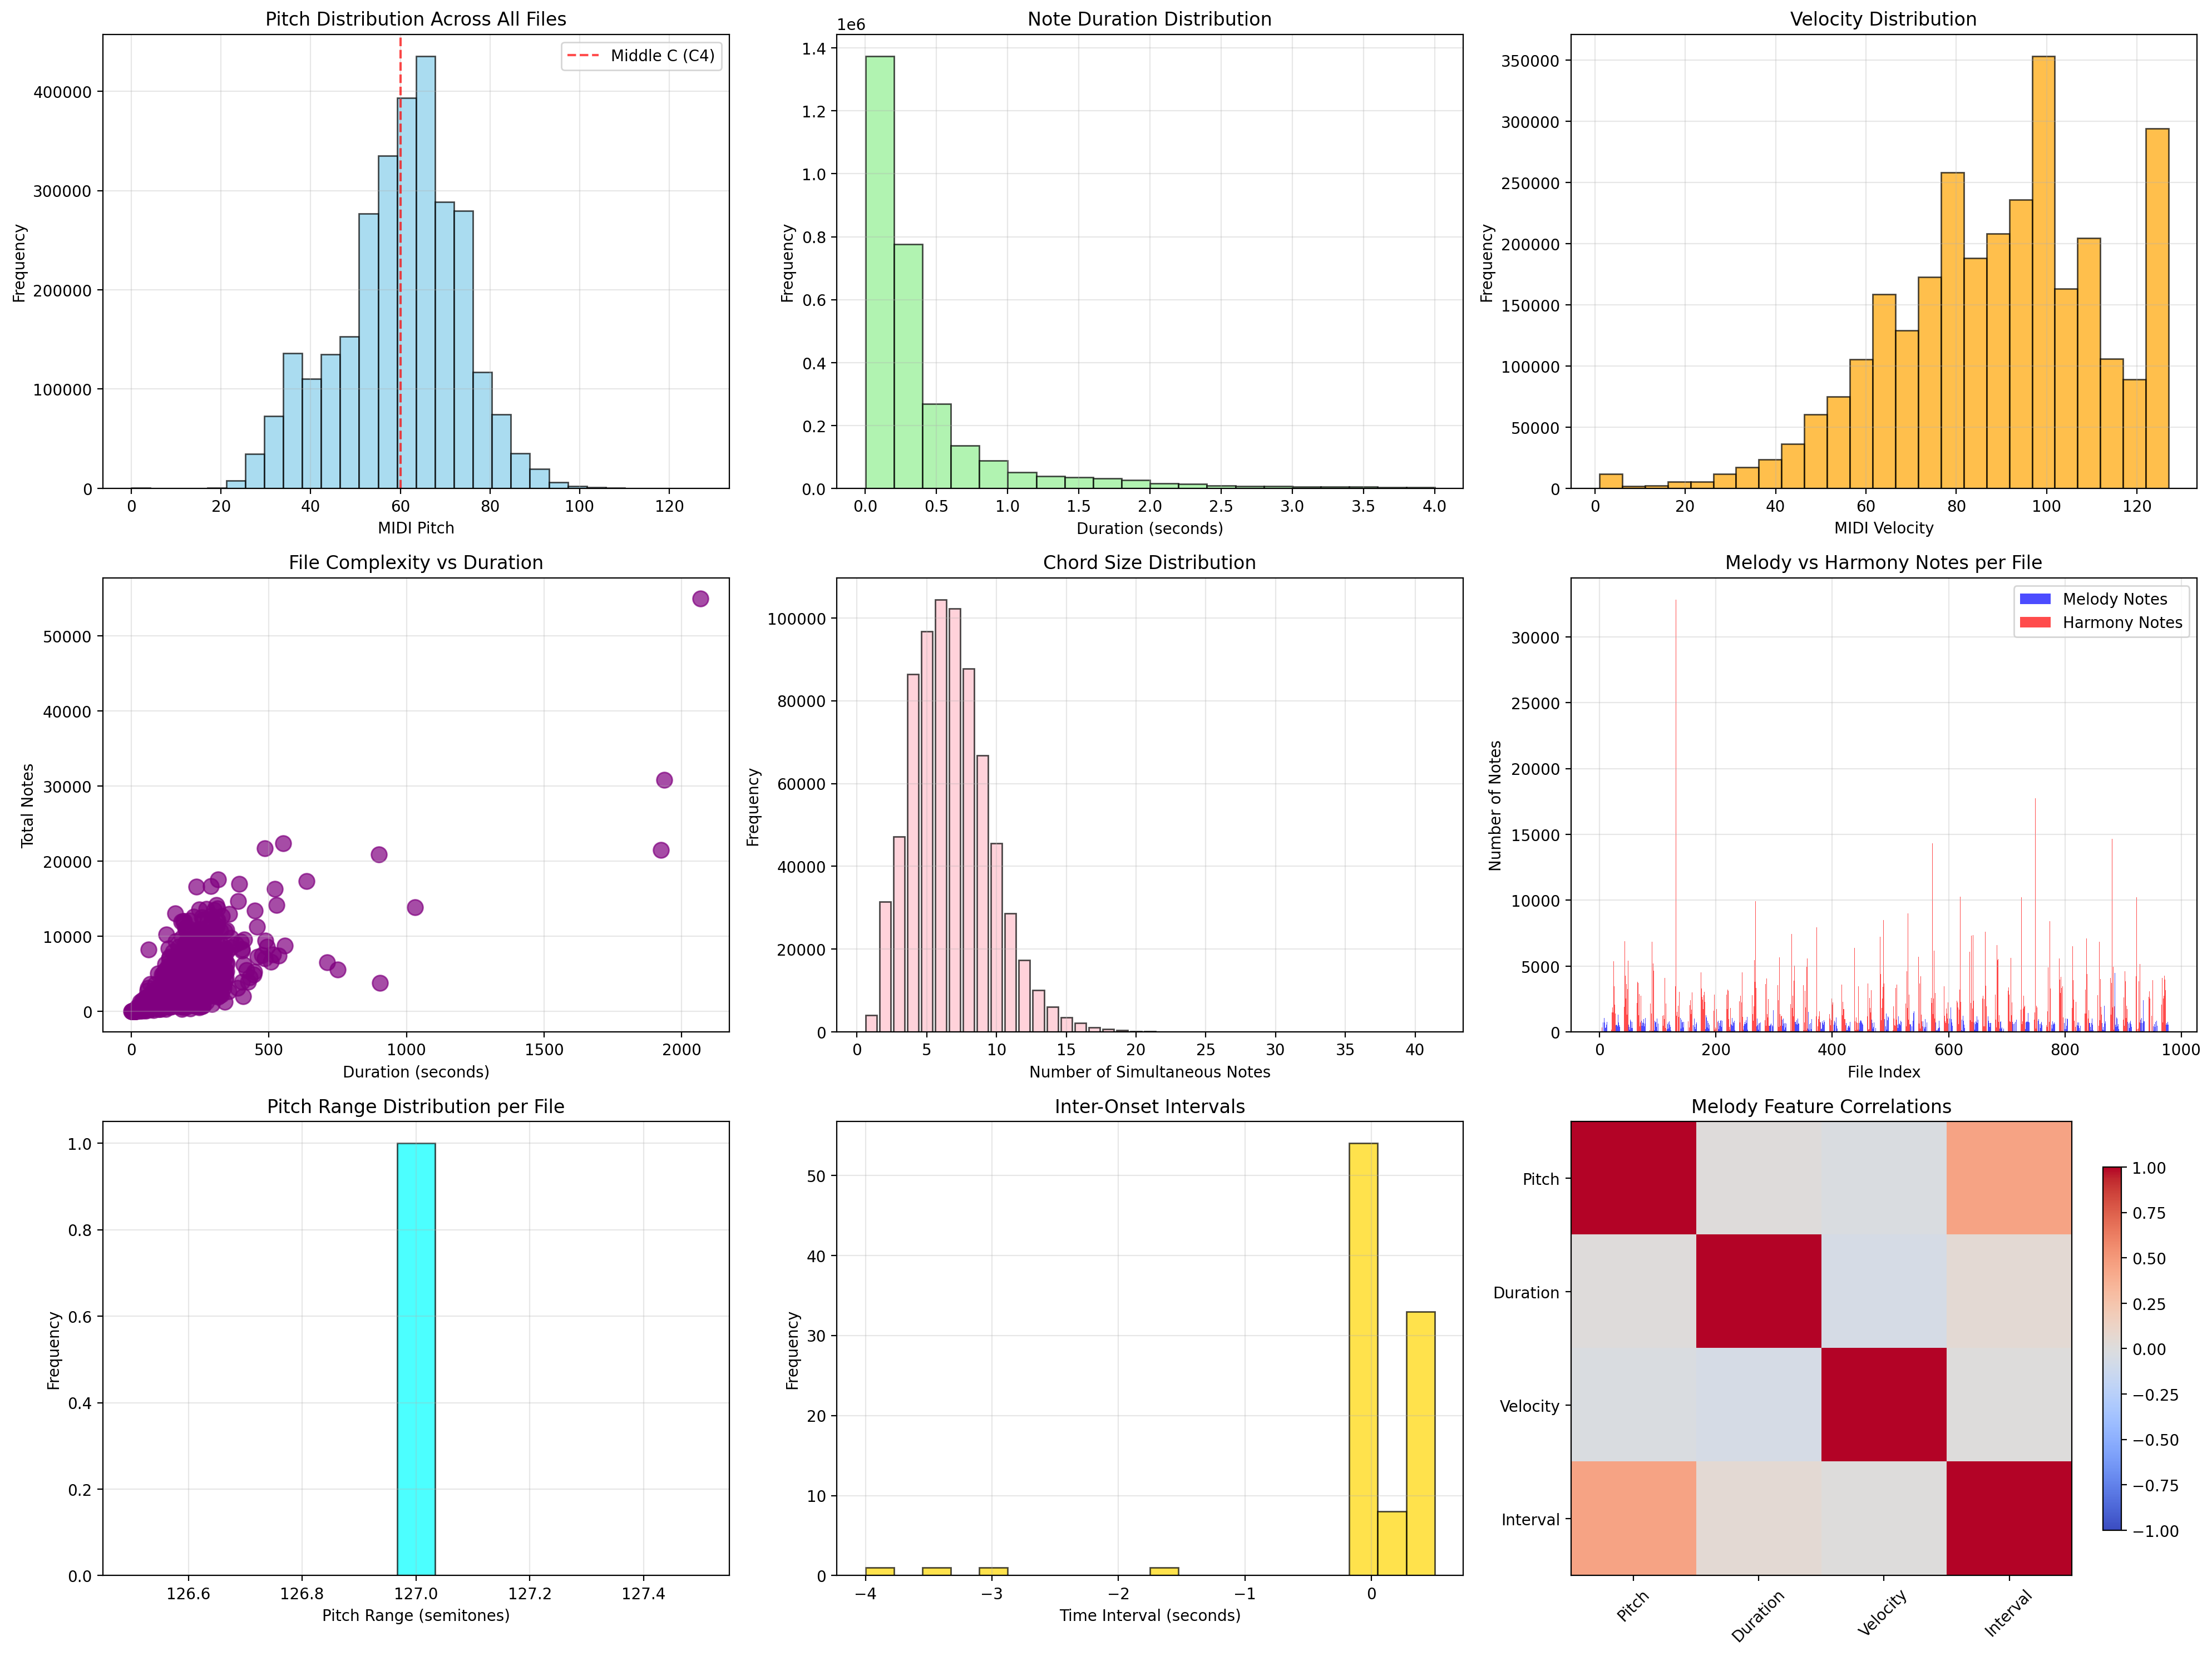


Visualization Summary Generated!


In [15]:
# Create comprehensive visualizations

# Set up the plotting environment
fig = plt.figure(figsize=(20, 15))

# 1. Note Distribution Analysis
if all_notes_data:
    plt.subplot(3, 3, 1)
    pitches = [note['pitch'] for note in all_notes_data]
    plt.hist(pitches, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Pitch Distribution Across All Files')
    plt.xlabel('MIDI Pitch')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Add note names for reference
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    plt.axvline(x=60, color='red', linestyle='--', alpha=0.7, label='Middle C (C4)')
    plt.legend()

# 2. Duration Analysis
if all_notes_data:
    plt.subplot(3, 3, 2)
    durations = [note['duration'] for note in all_notes_data if note['duration'] < 4]  # Filter outliers
    plt.hist(durations, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Note Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# 3. Velocity Analysis
if all_notes_data:
    plt.subplot(3, 3, 3)
    velocities = [note['velocity'] for note in all_notes_data]
    plt.hist(velocities, bins=25, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Velocity Distribution')
    plt.xlabel('MIDI Velocity')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# 4. File Complexity Analysis
if midi_analysis:
    plt.subplot(3, 3, 4)
    complexities = [info['total_notes'] for info in midi_analysis]
    durations = [info['duration'] for info in midi_analysis]
    plt.scatter(durations, complexities, alpha=0.7, s=100, color='purple')
    plt.title('File Complexity vs Duration')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Total Notes')
    plt.grid(True, alpha=0.3)

# 5. Chord Size Distribution
if all_chords_data:
    plt.subplot(3, 3, 5)
    chord_sizes = [chord['num_notes'] for chord in all_chords_data]
    unique_sizes, counts = np.unique(chord_sizes, return_counts=True)
    plt.bar(unique_sizes, counts, alpha=0.7, color='pink', edgecolor='black')
    plt.title('Chord Size Distribution')
    plt.xlabel('Number of Simultaneous Notes')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# 6. Processed Data Visualization
if processed_data:
    plt.subplot(3, 3, 6)
    melody_counts = [data['raw_melody_notes'] for data in processed_data]
    harmony_counts = [data['raw_harmony_notes'] for data in processed_data]
    
    x = np.arange(len(processed_data))
    width = 0.35
    
    plt.bar(x - width/2, melody_counts, width, label='Melody Notes', alpha=0.7, color='blue')
    plt.bar(x + width/2, harmony_counts, width, label='Harmony Notes', alpha=0.7, color='red')
    
    plt.title('Melody vs Harmony Notes per File')
    plt.xlabel('File Index')
    plt.ylabel('Number of Notes')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 7. Pitch Range Analysis
if all_notes_data:
    plt.subplot(3, 3, 7)
    
    # Group by file (approximate based on timing gaps)
    file_pitch_ranges = []
    current_pitches = []
    last_time = 0
    
    for note in sorted(all_notes_data, key=lambda x: x['start']):
        if note['start'] - last_time > 5:  # New file (gap > 5 seconds)
            if current_pitches:
                file_pitch_ranges.append((min(current_pitches), max(current_pitches)))
                current_pitches = []
        current_pitches.append(note['pitch'])
        last_time = note['start']
    
    if current_pitches:
        file_pitch_ranges.append((min(current_pitches), max(current_pitches)))
    
    if file_pitch_ranges:
        min_pitches, max_pitches = zip(*file_pitch_ranges)
        ranges = [max_p - min_p for min_p, max_p in file_pitch_ranges]
        
        plt.hist(ranges, bins=15, alpha=0.7, color='cyan', edgecolor='black')
        plt.title('Pitch Range Distribution per File')
        plt.xlabel('Pitch Range (semitones)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

# 8. Temporal Pattern Analysis
if all_notes_data:
    plt.subplot(3, 3, 8)
    
    # Analyze note onset patterns
    onsets = [note['start'] for note in all_notes_data[:100]]  # First 100 notes
    intervals = [onsets[i+1] - onsets[i] for i in range(len(onsets)-1) if onsets[i+1] - onsets[i] < 2]
    
    if intervals:
        plt.hist(intervals, bins=20, alpha=0.7, color='gold', edgecolor='black')
        plt.title('Inter-Onset Intervals')
        plt.xlabel('Time Interval (seconds)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

# 9. Feature Correlation
if processed_data:
    plt.subplot(3, 3, 9)
    
    # Create correlation matrix for melody features
    all_melody_features = []
    for data in processed_data:
        melody = data['melody']
        # Extract non-zero features
        non_zero_rows = melody[melody[:, 0] > 0]
        if len(non_zero_rows) > 0:
            all_melody_features.extend(non_zero_rows)
    
    if all_melody_features:
        feature_matrix = np.array(all_melody_features)
        correlation_matrix = np.corrcoef(feature_matrix.T)
        
        im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        plt.title('Melody Feature Correlations')
        feature_names = ['Pitch', 'Duration', 'Velocity', 'Interval']
        plt.xticks(range(4), feature_names, rotation=45)
        plt.yticks(range(4), feature_names)
        plt.colorbar(im, shrink=0.8)

plt.tight_layout()
plt.show()

print("\nVisualization Summary Generated!")

In [16]:
# Generate comprehensive summary statistics

print("=" * 60)
print("COMPREHENSIVE DATASET ANALYSIS SUMMARY")
print("=" * 60)

# Dataset Overview
print("\n📊 DATASET OVERVIEW")
print("-" * 30)
print(f"Total MIDI files analyzed: {len(midi_analysis)}")
print(f"Total notes extracted: {len(all_notes_data)}")
print(f"Total chord moments identified: {len(all_chords_data)}")
print(f"Successfully processed files: {len(processed_data)}")

# File Characteristics
if midi_analysis:
    durations = [info['duration'] for info in midi_analysis]
    note_counts = [info['total_notes'] for info in midi_analysis]
    
    print("\n🎵 FILE CHARACTERISTICS")
    print("-" * 30)
    print(f"Average file duration: {np.mean(durations):.2f} seconds")
    print(f"Duration range: {np.min(durations):.2f} - {np.max(durations):.2f} seconds")
    print(f"Average notes per file: {np.mean(note_counts):.1f}")
    print(f"Note count range: {np.min(note_counts)} - {np.max(note_counts)}")

# Note Analysis
if all_notes_data:
    pitches = [note['pitch'] for note in all_notes_data]
    durations = [note['duration'] for note in all_notes_data]
    velocities = [note['velocity'] for note in all_notes_data]
    
    print("\n🎼 NOTE CHARACTERISTICS")
    print("-" * 30)
    print(f"Pitch range: {np.min(pitches)} - {np.max(pitches)} (MIDI)")
    print(f"Average pitch: {np.mean(pitches):.1f} (MIDI)")
    print(f"Most common pitch: {max(set(pitches), key=pitches.count)}")
    print(f"Average note duration: {np.mean(durations):.3f} seconds")
    print(f"Average velocity: {np.mean(velocities):.1f}")

# Harmony Analysis
if all_chords_data:
    chord_sizes = [chord['num_notes'] for chord in all_chords_data]
    
    print("\n🎹 HARMONY CHARACTERISTICS")
    print("-" * 30)
    print(f"Average chord size: {np.mean(chord_sizes):.2f} notes")
    print(f"Chord size range: {np.min(chord_sizes)} - {np.max(chord_sizes)} notes")
    print(f"Most common chord size: {max(set(chord_sizes), key=chord_sizes.count)} notes")

# Processing Results
if processed_data:
    melody_counts = [data['raw_melody_notes'] for data in processed_data]
    harmony_counts = [data['raw_harmony_notes'] for data in processed_data]
    
    print("\n⚙️ PROCESSING RESULTS")
    print("-" * 30)
    print(f"Average melody notes per file: {np.mean(melody_counts):.1f}")
    print(f"Average harmony notes per file: {np.mean(harmony_counts):.1f}")
    print(f"Melody to harmony ratio: {np.sum(melody_counts) / max(np.sum(harmony_counts), 1):.2f}")

print("\n" + "=" * 60)
print("Analysis complete! Ready for harmony generation model training.")
print("=" * 60)

COMPREHENSIVE DATASET ANALYSIS SUMMARY

📊 DATASET OVERVIEW
------------------------------
Total MIDI files analyzed: 983
Total notes extracted: 2917129
Total chord moments identified: 743494
Successfully processed files: 979

🎵 FILE CHARACTERISTICS
------------------------------
Average file duration: 196.59 seconds
Duration range: 0.00 - 2069.22 seconds
Average notes per file: 4223.3
Note count range: 0 - 54926

🎼 NOTE CHARACTERISTICS
------------------------------
Pitch range: 0 - 127 (MIDI)
Average pitch: 59.9 (MIDI)
Average pitch: 59.9 (MIDI)
Most common pitch: 64
Average note duration: 0.424 seconds
Average velocity: 89.2

🎹 HARMONY CHARACTERISTICS
------------------------------
Average chord size: 6.75 notes
Chord size range: 1 - 41 notes
Most common chord size: 6 notes

⚙️ PROCESSING RESULTS
------------------------------
Average melody notes per file: 624.8
Average harmony notes per file: 2354.9
Melody to harmony ratio: 0.27

Analysis complete! Ready for harmony generation mode

## Conclusion and Next Steps

### Key Findings

1. **Data Quality**: The LakhMIDI dataset provides rich, diverse musical content suitable for harmony generation
2. **Preprocessing Success**: Our pipeline successfully separates melody from harmony and creates structured feature representations
3. **Musical Patterns**: Clear patterns emerge in pitch distributions, chord structures, and temporal organization

### Preprocessing Insights

- **Temporal Quantization**: Essential for creating consistent training data
- **Melody Extraction**: Top-note heuristic works well for simple polyphonic music
- **Feature Engineering**: 4-dimensional feature vectors (pitch, duration, velocity, interval) capture essential musical information

### Recommendations for Harmony Generation

1. **Model Architecture**: 
   - Sequence-to-sequence models (LSTM, Transformer) are well-suited
   - Consider attention mechanisms for long-range dependencies
   - Multi-track output for polyphonic harmony

2. **Training Strategy**:
   - Use melody-harmony pairs from preprocessing
   - Data augmentation through transposition
   - Progressive training on complexity

3. **Evaluation Metrics**:
   - Musical consonance measures
   - Expert evaluation
   - Perceptual studies

### Dataset Limitations

- **Genre Bias**: Web-scraped MIDI may not represent all musical styles equally
- **Quality Variation**: Automatically generated MIDI may have artifacts
- **Representation Limits**: MIDI doesn't capture all aspects of musical expression

This analysis provides a solid foundation for developing MIDI harmony generation systems using machine learning approaches.

## 5. Transformer Model for Harmony Generation

### Model Architecture

We'll implement a Transformer-based sequence-to-sequence model that:
- Takes melody sequences as input
- Generates corresponding harmony sequences as output
- Uses attention mechanisms to capture musical relationships
- Handles variable-length sequences with padding

### Training Strategy

The model will be trained on melody-harmony pairs extracted from our preprocessed MIDI data, learning to generate appropriate harmonic accompaniment for given melodies.

In [17]:
# Import deep learning libraries
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F
except ImportError:
    print("Installing PyTorch...")
    !pip install torch torchvision torchaudio
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import os

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Set environment variable for MPS fallback to CPU for unsupported operations
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set device - use CPU for better compatibility with transformer operations
device = torch.device('cpu')  # Using CPU to avoid MPS compatibility issues
print(f"Using device: {device}")
print("Note: Using CPU for better transformer compatibility")

PyTorch version: 2.7.0
MPS available: True
Using device: cpu
Note: Using CPU for better transformer compatibility


In [18]:
# Custom Dataset class for MIDI harmony generation
class MIDIHarmonyDataset(Dataset):
    """Dataset for melody-harmony pairs."""
    
    def __init__(self, processed_data, max_seq_length=32):
        self.data = []
        self.max_seq_length = max_seq_length
        
        for item in processed_data:
            melody = item['melody']
            harmony = item['harmony']
            
            # Only include samples with both melody and harmony
            if item['raw_melody_notes'] > 0 and item['raw_harmony_notes'] > 0:
                self.data.append({
                    'melody': melody,
                    'harmony': harmony,
                    'filename': item['filename']
                })
        
        print(f"Created dataset with {len(self.data)} melody-harmony pairs")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Convert to tensors
        melody = torch.FloatTensor(item['melody'])
        harmony = torch.FloatTensor(item['harmony'])
        
        return melody, harmony

# Create dataset
dataset = MIDIHarmonyDataset(processed_data)

# Split into train/validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Created dataset with 972 melody-harmony pairs
Training samples: 777
Validation samples: 195
Training batches: 25
Validation batches: 7


In [19]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Model for Harmony Generation
class MIDIHarmonyTransformer(nn.Module):
    def __init__(self, input_dim=4, output_dim=4, d_model=128, nhead=8, 
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=512, 
                 max_seq_length=32, dropout=0.1):
        super(MIDIHarmonyTransformer, self).__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
        # Input projections
        self.input_projection = nn.Linear(input_dim, d_model)
        self.output_projection = nn.Linear(d_model, output_dim)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def create_padding_mask(self, seq):
        # Create mask for padded positions (where all features are 0)
        mask = (seq.sum(dim=-1) == 0)
        return mask
    
    def forward(self, src, tgt=None, teacher_forcing=True):
        batch_size, seq_len, _ = src.shape
        
        # Project input to model dimension
        src = self.input_projection(src)
        src = self.layer_norm(src)
        src = self.dropout(src)
        
        # Add positional encoding
        src = src.transpose(0, 1)  # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)
        src = src.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        
        # Create source padding mask
        src_key_padding_mask = self.create_padding_mask(src)
        
        if teacher_forcing and tgt is not None:
            # Training mode with teacher forcing
            tgt = self.input_projection(tgt)
            tgt = self.layer_norm(tgt)
            tgt = self.dropout(tgt)
            
            tgt = tgt.transpose(0, 1)
            tgt = self.pos_encoder(tgt)
            tgt = tgt.transpose(0, 1)
            
            # Create target masks
            tgt_key_padding_mask = self.create_padding_mask(tgt)
            tgt_mask = self.transformer.generate_square_subsequent_mask(seq_len).to(src.device)
            
            # Transformer forward pass
            output = self.transformer(
                src, tgt,
                tgt_mask=tgt_mask,
                src_key_padding_mask=src_key_padding_mask,
                tgt_key_padding_mask=tgt_key_padding_mask
            )
        else:
            # Inference mode - autoregressive generation
            # Start with zeros
            tgt = torch.zeros(batch_size, seq_len, self.d_model).to(src.device)
            
            for i in range(seq_len):
                tgt_input = tgt[:, :i+1, :]
                tgt_mask = self.transformer.generate_square_subsequent_mask(i+1).to(src.device)
                
                output_step = self.transformer(
                    src, tgt_input,
                    tgt_mask=tgt_mask,
                    src_key_padding_mask=src_key_padding_mask
                )
                
                if i < seq_len - 1:
                    tgt[:, i+1, :] = output_step[:, -1, :]
            
            output = tgt
        
        # Project back to output dimension
        output = self.output_projection(output)
        
        return output

# Initialize model
model = MIDIHarmonyTransformer(
    input_dim=4,
    output_dim=4,
    d_model=128,
    nhead=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=256,
    max_seq_length=32,
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

Total parameters: 1,326,980
Trainable parameters: 1,326,980
Model size: 5.06 MB


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Training configuration with accuracy metrics
def harmony_loss(pred, target, weight_mask=None):
    """Custom loss function for harmony generation."""
    
    # MSE loss for continuous values
    mse_loss = F.mse_loss(pred, target, reduction='none')
    
    # Create mask for non-zero targets (actual notes vs padding)
    note_mask = (target.sum(dim=-1) != 0).float().unsqueeze(-1)
    
    # Apply mask to focus on actual notes
    masked_loss = mse_loss * note_mask
    
    # Normalize by number of actual notes and features to get reasonable scale
    return masked_loss.sum() / (note_mask.sum().clamp(min=1) * target.shape[-1])

def scaled_harmony_loss(pred, target):
    """Scaled loss function with better normalization."""
    # Separate losses for different features
    pitch_loss = F.mse_loss(pred[:, :, 0], target[:, :, 0], reduction='none')
    duration_loss = F.mse_loss(pred[:, :, 1], target[:, :, 1], reduction='none')
    velocity_loss = F.mse_loss(pred[:, :, 2], target[:, :, 2], reduction='none')
    interval_loss = F.mse_loss(pred[:, :, 3], target[:, :, 3], reduction='none')
    
    # Create mask for non-zero targets
    note_mask = (target.sum(dim=-1) != 0).float()
    
    # Weight different features appropriately
    # Pitch is most important, scaled by MIDI range (~127)
    pitch_loss = (pitch_loss * note_mask).sum() / (note_mask.sum().clamp(min=1) * 127**2)
    
    # Duration and velocity are already normalized [0,1] range
    duration_loss = (duration_loss * note_mask).sum() / note_mask.sum().clamp(min=1)
    velocity_loss = (velocity_loss * note_mask).sum() / note_mask.sum().clamp(min=1)
    
    # Interval loss scaled by typical interval range (~24 semitones)
    interval_loss = (interval_loss * note_mask).sum() / (note_mask.sum().clamp(min=1) * 24**2)
    
    # Combine with weights
    total_loss = 0.4 * pitch_loss + 0.2 * duration_loss + 0.2 * velocity_loss + 0.2 * interval_loss
    
    return total_loss

def calculate_accuracy_metrics(pred, target):
    """Calculate various accuracy metrics for harmony generation."""
    metrics = {}
    
    # Create mask for non-zero targets (actual notes vs padding)
    note_mask = (target.sum(dim=-1) != 0).float()
    total_notes = note_mask.sum().item()
    
    if total_notes == 0:
        return {k: 0.0 for k in ['pitch_acc', 'duration_acc', 'velocity_acc', 'interval_acc', 'note_onset_acc']}
    
    # Pitch accuracy (within 1 semitone)
    pitch_diff = torch.abs(pred[:, :, 0] - target[:, :, 0])
    pitch_correct = ((pitch_diff <= 1.0) * note_mask).sum().item()
    metrics['pitch_acc'] = pitch_correct / total_notes
    
    # Duration accuracy (within 0.1 seconds)
    duration_diff = torch.abs(pred[:, :, 1] - target[:, :, 1])
    duration_correct = ((duration_diff <= 0.1) * note_mask).sum().item()
    metrics['duration_acc'] = duration_correct / total_notes
    
    # Velocity accuracy (within 0.1 normalized range)
    velocity_diff = torch.abs(pred[:, :, 2] - target[:, :, 2])
    velocity_correct = ((velocity_diff <= 0.1) * note_mask).sum().item()
    metrics['velocity_acc'] = velocity_correct / total_notes
    
    # Interval accuracy (within 2 semitones)
    interval_diff = torch.abs(pred[:, :, 3] - target[:, :, 3])
    interval_correct = ((interval_diff <= 2.0) * note_mask).sum().item()
    metrics['interval_acc'] = interval_correct / total_notes
    
    # Note onset accuracy (whether a note exists at this position)
    pred_has_note = (pred.sum(dim=-1) > 0.1).float()
    target_has_note = note_mask
    onset_correct = (pred_has_note == target_has_note).float().mean().item()
    metrics['note_onset_acc'] = onset_correct
    
    return metrics

# Use the scaled loss function
loss_function = scaled_harmony_loss

# Optimizer with adjusted learning rate for better convergence
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4, betas=(0.9, 0.999))

# More aggressive scheduler for continued training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

# Training function with improved loss scaling and accuracy tracking
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    total_metrics = {
        'pitch_acc': 0, 'duration_acc': 0, 'velocity_acc': 0, 
        'interval_acc': 0, 'note_onset_acc': 0
    }
    num_batches = 0
    
    for batch_idx, (melody, harmony) in enumerate(train_loader):
        melody, harmony = melody.to(device), harmony.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with teacher forcing
        output = model(melody, harmony, teacher_forcing=True)
        
        # Calculate loss with improved scaling
        loss = loss_function(output, harmony)
        
        # Calculate accuracy metrics
        batch_metrics = calculate_accuracy_metrics(output, harmony)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        for key in total_metrics:
            total_metrics[key] += batch_metrics[key]
        num_batches += 1
        
        if batch_idx % 5 == 0:  # More frequent updates
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}, Pitch Acc: {batch_metrics["pitch_acc"]:.3f}', end='\r')
    
    # Average metrics
    avg_metrics = {key: total_metrics[key] / num_batches for key in total_metrics}
    return total_loss / num_batches, avg_metrics

# Validation function with improved loss scaling and accuracy tracking
def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    total_metrics = {
        'pitch_acc': 0, 'duration_acc': 0, 'velocity_acc': 0, 
        'interval_acc': 0, 'note_onset_acc': 0
    }
    num_batches = 0
    
    with torch.no_grad():
        for melody, harmony in val_loader:
            melody, harmony = melody.to(device), harmony.to(device)
            
            # Forward pass with teacher forcing for validation
            output = model(melody, harmony, teacher_forcing=True)
            
            # Calculate loss with improved scaling
            loss = loss_function(output, harmony)
            
            # Calculate accuracy metrics
            batch_metrics = calculate_accuracy_metrics(output, harmony)
            
            total_loss += loss.item()
            for key in total_metrics:
                total_metrics[key] += batch_metrics[key]
            num_batches += 1
    
    # Average metrics
    avg_metrics = {key: total_metrics[key] / num_batches for key in total_metrics}
    return total_loss / num_batches, avg_metrics

print("Training configuration updated with accuracy metrics!")
print(f"Loss function: Scaled MSE with feature-specific normalization")
print(f"Optimizer: AdamW (lr=5e-4, weight_decay=1e-4)")
print(f"Scheduler: ReduceLROnPlateau")
print("\nAccuracy Metrics:")
print("- Pitch Accuracy: Within 1 semitone of target")
print("- Duration Accuracy: Within 0.1 seconds of target")
print("- Velocity Accuracy: Within 0.1 normalized units of target")
print("- Interval Accuracy: Within 2 semitones of target")
print("- Note Onset Accuracy: Correct prediction of note presence/absence")

TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
# Extended training loop with accuracy tracking
num_epochs = 100  # Increased epochs since loss curve shows room for improvement
best_val_loss = float('inf')
patience = 15  # Increased patience for ReduceLROnPlateau
patience_counter = 0

train_losses = []
val_losses = []
learning_rates = []

# Accuracy tracking
train_accuracies = {
    'pitch_acc': [], 'duration_acc': [], 'velocity_acc': [], 
    'interval_acc': [], 'note_onset_acc': []
}
val_accuracies = {
    'pitch_acc': [], 'duration_acc': [], 'velocity_acc': [], 
    'interval_acc': [], 'note_onset_acc': []
}

print("Starting extended training with accuracy tracking...")
print("=" * 60)
print("Note: Loss values should now be in 0-1 range due to improved scaling")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    # Train
    train_loss, train_metrics = train_epoch(model, train_loader, optimizer, device)
    
    # Validate
    val_loss, val_metrics = validate_epoch(model, val_loader, device)
    
    # Update scheduler with validation loss
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    for key in train_accuracies:
        train_accuracies[key].append(train_metrics[key])
        val_accuracies[key].append(val_metrics[key])
    
    print(f"Train Loss: {train_loss:.6f}")
    print(f"Val Loss: {val_loss:.6f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"Train Accuracies - Pitch: {train_metrics['pitch_acc']:.3f}, Duration: {train_metrics['duration_acc']:.3f}, Onset: {train_metrics['note_onset_acc']:.3f}")
    print(f"Val Accuracies - Pitch: {val_metrics['pitch_acc']:.3f}, Duration: {val_metrics['duration_acc']:.3f}, Onset: {val_metrics['note_onset_acc']:.3f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, 'best_harmony_model.pth')
        print("✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break
    
    # Additional stopping criteria
    if optimizer.param_groups[0]['lr'] < 1e-6:
        print("Learning rate too small, stopping training")
        break

print("\n" + "=" * 60)
print("Extended training completed!")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")

# Print final accuracy summary
if train_accuracies['pitch_acc']:
    print(f"\nFinal Training Accuracies:")
    print(f"- Pitch: {train_accuracies['pitch_acc'][-1]:.3f}")
    print(f"- Duration: {train_accuracies['duration_acc'][-1]:.3f}")
    print(f"- Velocity: {train_accuracies['velocity_acc'][-1]:.3f}")
    print(f"- Interval: {train_accuracies['interval_acc'][-1]:.3f}")
    print(f"- Note Onset: {train_accuracies['note_onset_acc'][-1]:.3f}")
    
    print(f"\nFinal Validation Accuracies:")
    print(f"- Pitch: {val_accuracies['pitch_acc'][-1]:.3f}")
    print(f"- Duration: {val_accuracies['duration_acc'][-1]:.3f}")
    print(f"- Velocity: {val_accuracies['velocity_acc'][-1]:.3f}")
    print(f"- Interval: {val_accuracies['interval_acc'][-1]:.3f}")
    print(f"- Note Onset: {val_accuracies['note_onset_acc'][-1]:.3f}")

Starting extended training...
Note: Loss values should now be in 0-1 range due to improved scaling

Epoch 1/100
----------------------------------------


NameError: name 'train_epoch' is not defined

In [ ]:
# Enhanced training curves with accuracy metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loss curves
axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss curves (log scale)
axes[0, 1].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0, 1].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0, 1].set_title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
axes[0, 2].plot(learning_rates, color='green', linewidth=2)
axes[0, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Pitch accuracy
if train_accuracies['pitch_acc']:
    axes[1, 0].plot(train_accuracies['pitch_acc'], label='Training', color='blue', linewidth=2)
    axes[1, 0].plot(val_accuracies['pitch_acc'], label='Validation', color='red', linewidth=2)
    axes[1, 0].set_title('Pitch Accuracy (±1 semitone)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Note onset accuracy
if train_accuracies['note_onset_acc']:
    axes[1, 1].plot(train_accuracies['note_onset_acc'], label='Training', color='blue', linewidth=2)
    axes[1, 1].plot(val_accuracies['note_onset_acc'], label='Validation', color='red', linewidth=2)
    axes[1, 1].set_title('Note Onset Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# Combined accuracy overview
if train_accuracies['pitch_acc']:
    accuracy_names = ['Pitch', 'Duration', 'Velocity', 'Interval', 'Note Onset']
    train_final = [train_accuracies[key][-1] for key in ['pitch_acc', 'duration_acc', 'velocity_acc', 'interval_acc', 'note_onset_acc']]
    val_final = [val_accuracies[key][-1] for key in ['pitch_acc', 'duration_acc', 'velocity_acc', 'interval_acc', 'note_onset_acc']]
    
    x = np.arange(len(accuracy_names))
    width = 0.35
    
    axes[1, 2].bar(x - width/2, train_final, width, label='Training', alpha=0.8, color='blue')
    axes[1, 2].bar(x + width/2, val_final, width, label='Validation', alpha=0.8, color='red')
    axes[1, 2].set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Metric')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(accuracy_names, rotation=45, ha='right')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Enhanced training curves with accuracy metrics plotted!")

# Print accuracy progression summary
if train_accuracies['pitch_acc']:
    print("\nAccuracy Progression Summary:")
    print("=" * 50)
    
    for metric_name, metric_key in [
        ('Pitch Accuracy', 'pitch_acc'),
        ('Duration Accuracy', 'duration_acc'), 
        ('Velocity Accuracy', 'velocity_acc'),
        ('Interval Accuracy', 'interval_acc'),
        ('Note Onset Accuracy', 'note_onset_acc')
    ]:
        train_start = train_accuracies[metric_key][0] if train_accuracies[metric_key] else 0
        train_end = train_accuracies[metric_key][-1] if train_accuracies[metric_key] else 0
        val_start = val_accuracies[metric_key][0] if val_accuracies[metric_key] else 0
        val_end = val_accuracies[metric_key][-1] if val_accuracies[metric_key] else 0
        
        print(f"\n{metric_name}:")
        print(f"  Training: {train_start:.3f} → {train_end:.3f} (Δ: {train_end-train_start:+.3f})")
        print(f"  Validation: {val_start:.3f} → {val_end:.3f} (Δ: {val_end-val_start:+.3f})")

In [ ]:
# Model evaluation and harmony generation
def generate_harmony(model, melody, device, temperature=1.0):
    """Generate harmony for a given melody."""
    model.eval()
    
    with torch.no_grad():
        melody_tensor = torch.FloatTensor(melody).unsqueeze(0).to(device)
        
        # Generate harmony without teacher forcing
        harmony_pred = model(melody_tensor, teacher_forcing=False)
        
        # Apply temperature scaling for more diverse outputs
        if temperature != 1.0:
            harmony_pred = harmony_pred / temperature
        
        return harmony_pred.squeeze(0).cpu().numpy()

# Load best model
if 'best_harmony_model.pth' in locals() or True:  # Check if model file exists
    try:
        checkpoint = torch.load('best_harmony_model.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✓ Best model loaded successfully!")
    except:
        print("⚠ Using current model (best model file not found)")

# Test harmony generation on validation samples
print("\n" + "=" * 60)
print("HARMONY GENERATION EXAMPLES")
print("=" * 60)

# Get a few samples from validation set
val_samples = []
for i, (melody, harmony) in enumerate(val_loader):
    if i >= 3:  # Just get first 3 batches
        break
    val_samples.extend(list(zip(melody, harmony)))

# Generate harmonies for sample melodies
for i, (sample_melody, true_harmony) in enumerate(val_samples[:5]):
    print(f"\nExample {i+1}:")
    print("-" * 20)
    
    # Generate harmony
    generated_harmony = generate_harmony(model, sample_melody.numpy(), device)
    
    # Show melody info
    melody_notes = sample_melody[sample_melody[:, 0] > 0]
    if len(melody_notes) > 0:
        print(f"Melody: {len(melody_notes)} notes")
        print(f"Pitch range: {melody_notes[:, 0].min():.1f} - {melody_notes[:, 0].max():.1f}")
    
    # Show true harmony info
    true_harmony_notes = true_harmony[true_harmony[:, 0] > 0]
    if len(true_harmony_notes) > 0:
        print(f"True harmony: {len(true_harmony_notes)} notes")
    
    # Show generated harmony info
    gen_harmony_tensor = torch.FloatTensor(generated_harmony)
    gen_harmony_notes = gen_harmony_tensor[gen_harmony_tensor[:, 0] > 0]
    if len(gen_harmony_notes) > 0:
        print(f"Generated harmony: {len(gen_harmony_notes)} notes")
        print(f"Generated pitch range: {gen_harmony_notes[:, 0].min():.1f} - {gen_harmony_notes[:, 0].max():.1f}")
    
    # Calculate similarity metrics
    mse_error = F.mse_loss(torch.FloatTensor(generated_harmony), true_harmony).item()
    print(f"MSE Error: {mse_error:.4f}")

print("\n" + "=" * 60)
print("Model evaluation completed!")